# 🕹️ Hyperparameter tuning
In this guide, a simple hyperparameter tuning using `optuna` is demonstrated.

In [ ]:
!pip install serket --quiet
!pip install optuna --quiet

## Imports

In [1]:
import serket as sk
import jax
import jax.numpy as jnp
import optax
import optuna
from tqdm.notebook import tqdm

## Train step

In [2]:
key = jax.random.key(42)
x = jnp.linspace(-1, 1, 100)[..., None]
y = jnp.sin(x * 3.14) + jax.random.normal(key, (100, 1)) * 0.01 + 0.5
EPOCHS = 1000


def objective(trial):
    k1, k2 = jax.random.split(jax.random.key(0), 2)

    # hidden features selection from 1 to 50
    features = trial.suggest_int("hidden_features", 1, 50)
    # learning rate selection from 1e-4 to 1e-1
    learning_rate = trial.suggest_float("lr", 1e-4, 1e-1, log=True)
    # optimizer selection from adam, sgd
    optimizer = trial.suggest_categorical("optimizer", ["adam", "sgd"])
    # initialization selection from he_normal, glorot_normal
    init = trial.suggest_categorical("initialization", ["he_normal", "glorot_normal"])
    # activation selection from relu, tanh
    act_map = dict(relu=jax.nn.relu, tanh=jax.nn.tanh)
    act = act_map[trial.suggest_categorical("activation function", ["relu", "tanh"])]

    net = sk.Sequential(
        sk.nn.Linear(1, features, weight_init=init, key=k1),
        act,
        sk.nn.Linear(features, 1, weight_init=init, key=k2),
    )

    net = sk.tree_mask(net)
    optim = getattr(optax, optimizer)(learning_rate=learning_rate)
    optim_state = optim.init(net)

    @jax.jit
    def train_step(
        net: sk.Sequential,
        optim_state: optax.OptState,
        x: jax.Array,
        y: jax.Array,
    ) -> sk.Sequential:
        def mse(ytrue, ypred):
            assert ytrue.shape == ypred.shape
            return jnp.mean((ytrue - ypred) ** 2)

        def loss_func(net, x, y):
            net = sk.tree_unmask(net)
            ypred = jax.vmap(net)(x)
            loss = mse(y, ypred)
            return loss

        loss, grad = jax.value_and_grad(loss_func)(net, x, y)
        updates, optim_state = optim.update(grad, optim_state, net)
        net = optax.apply_updates(net, updates)
        return net, optim_state, loss

    tbar = tqdm(range(EPOCHS))
    for _ in tbar:
        net, optim_state, loss = train_step(net, optim_state, x, y)
        tbar.set_description(f"loss: {loss:.4f}")

    # return the metric to be optimized
    return loss

## Define the study

In [3]:
study = optuna.create_study(direction="minimize")

[I 2023-09-29 21:09:52,616] A new study created in memory with name: no-name-16a0365d-fd42-4ffc-bd79-2fe871c1d357


## Start study

In [4]:
study.optimize(objective, n_trials=10)

  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2023-09-29 21:09:56,319] Trial 0 finished with value: 0.0011207667412236333 and parameters: {'hidden_features': 17, 'lr': 0.00825869181268387, 'optimizer': 'adam', 'initialization': 'he_normal', 'activation function': 'tanh'}. Best is trial 0 with value: 0.0011207667412236333.


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2023-09-29 21:09:57,123] Trial 1 finished with value: 0.0008028973243199289 and parameters: {'hidden_features': 45, 'lr': 0.0019814666321393997, 'optimizer': 'adam', 'initialization': 'glorot_normal', 'activation function': 'relu'}. Best is trial 1 with value: 0.0008028973243199289.


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2023-09-29 21:09:57,634] Trial 2 finished with value: 0.12417665123939514 and parameters: {'hidden_features': 20, 'lr': 0.018312088181874454, 'optimizer': 'sgd', 'initialization': 'glorot_normal', 'activation function': 'tanh'}. Best is trial 1 with value: 0.0008028973243199289.


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2023-09-29 21:09:58,153] Trial 3 finished with value: 0.0006211642175912857 and parameters: {'hidden_features': 40, 'lr': 0.026646612574400562, 'optimizer': 'adam', 'initialization': 'he_normal', 'activation function': 'tanh'}. Best is trial 3 with value: 0.0006211642175912857.


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2023-09-29 21:09:58,871] Trial 4 finished with value: 0.09805890917778015 and parameters: {'hidden_features': 12, 'lr': 0.0006888743399274645, 'optimizer': 'adam', 'initialization': 'he_normal', 'activation function': 'relu'}. Best is trial 3 with value: 0.0006211642175912857.


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2023-09-29 21:09:59,381] Trial 5 finished with value: 0.00010031948477262631 and parameters: {'hidden_features': 29, 'lr': 0.018516682771811458, 'optimizer': 'adam', 'initialization': 'he_normal', 'activation function': 'relu'}. Best is trial 5 with value: 0.00010031948477262631.


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2023-09-29 21:10:00,039] Trial 6 finished with value: 0.23986369371414185 and parameters: {'hidden_features': 26, 'lr': 0.0002932405836243085, 'optimizer': 'sgd', 'initialization': 'glorot_normal', 'activation function': 'tanh'}. Best is trial 5 with value: 0.00010031948477262631.


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2023-09-29 21:10:00,331] Trial 7 finished with value: 0.18617339432239532 and parameters: {'hidden_features': 26, 'lr': 0.0006595062506786032, 'optimizer': 'sgd', 'initialization': 'he_normal', 'activation function': 'relu'}. Best is trial 5 with value: 0.00010031948477262631.


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2023-09-29 21:10:00,879] Trial 8 finished with value: 0.05963616073131561 and parameters: {'hidden_features': 40, 'lr': 0.00041347777105107286, 'optimizer': 'adam', 'initialization': 'he_normal', 'activation function': 'relu'}. Best is trial 5 with value: 0.00010031948477262631.


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2023-09-29 21:10:01,541] Trial 9 finished with value: 0.11352915316820145 and parameters: {'hidden_features': 24, 'lr': 0.016437918062061522, 'optimizer': 'sgd', 'initialization': 'glorot_normal', 'activation function': 'relu'}. Best is trial 5 with value: 0.00010031948477262631.


## Visualize best plots

/var/folders/mv/cckpw89s2jjd622p9pywk0nm0000gn/T/ipykernel_36566/1036994904.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)


<Axes: title={'center': 'Hyperparameter Importances'}, xlabel='Importance for Objective Value', ylabel='Hyperparameter'>

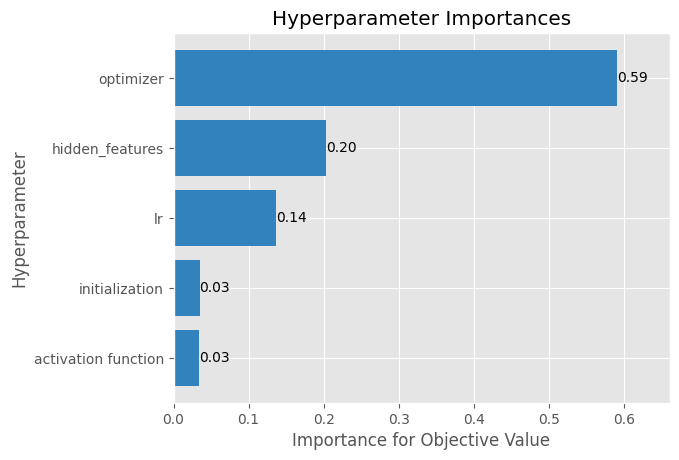

In [5]:
optuna.visualization.matplotlib.plot_param_importances(study)

In [6]:
study.best_params

{'hidden_features': 29,
 'lr': 0.018516682771811458,
 'optimizer': 'adam',
 'initialization': 'he_normal',
 'activation function': 'relu'}